# Fine-tune  Visual Question Answering using Consumer GPU with QLoRA


In [18]:
!nvidia-smi

Sun Dec 22 12:08:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:19:00.0 Off |                  N/A |
|  0%   22C    P8              19W / 350W |     10MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:

import IPython
import sys

def clean_notebook():
    IPython.display.clear_output(wait=True)
    print("Notebook cleaned.")

!pip install flash-attn --no-build-isolation 
#!pip install -q accelerate datasets peft bitsandbytes tensorboard

# Clean up the notebook
clean_notebook()



We will push out model to Hub so we need to authenticate ourselves.

In [4]:
from huggingface_hub import notebook_login

notebook_login()

In [19]:
from datasets import load_dataset
ds = load_dataset('merve/vqav2-small', trust_remote_code=True).pop("validation")
split_ds = ds.train_test_split(test_size=0.3)
train_ds = split_ds["train"]
val_ds  = split_ds["test"]

In [20]:
train_ds

Dataset({
    features: ['multiple_choice_answer', 'question', 'image'],
    num_rows: 15004
})

In [21]:
val_ds

Dataset({
    features: ['multiple_choice_answer', 'question', 'image'],
    num_rows: 6431
})

In [11]:
train_ds[0]

{'multiple_choice_answer': 'restaurant',
 'question': 'Where is this taken?',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>}

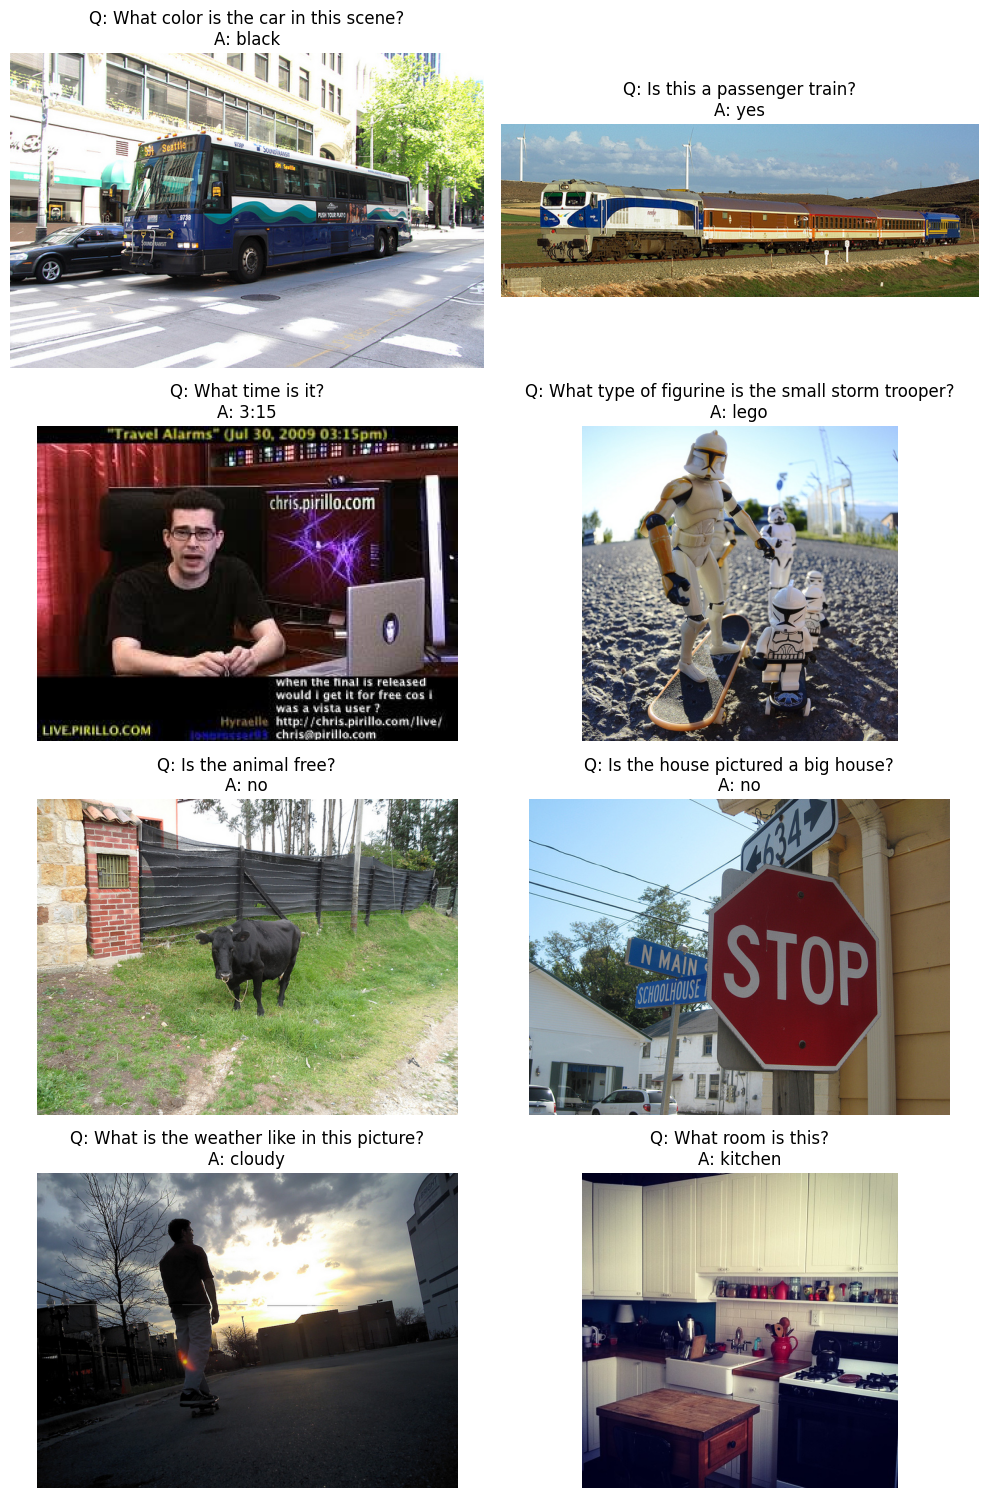

In [22]:
import random
import matplotlib.pyplot as plt

def random_plot(dataset, rows=2, cols=2, figsize=(10, 10)):
    """
    Displays a grid of random examples from the dataset.

    Parameters:
        dataset (list): A list of dictionaries where each dictionary contains 'image', 'question', and 'multiple_choice_answer'.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure.

    Returns:
        None
    """
    fig, axs = plt.subplots(rows, cols, figsize=figsize)

    for i in range(rows):
        for j in range(cols):
            idx = random.randint(0, len(dataset) - 1)
            example = dataset[idx]
            img = example['image']
            question = example['question']
            answer = example['multiple_choice_answer']

            axs[i, j].imshow(img)
            axs[i, j].set_title(f"Q: {question}\nA: {answer}")
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage:

random_plot(train_ds, rows=4, cols=2, figsize=(10, 15))


In this notebook we will not do full fine-tuning but use QLoRA method, which loads an adapter to the quantized version of the model, saving space. If you want to do full fine-tuning, set `USE_LORA` and `USE_QLORA` to False. If you want to do LoRA, set `USE_QLORA` to False and `USE_LORA` to True.

In [2]:
import torch
from peft import LoraConfig, prepare_model_for_kbit_training, get_peft_model
from transformers import AutoProcessor, BitsAndBytesConfig, Idefics3ForConditionalGeneration

USE_LORA = False
USE_QLORA = True
SMOL = True

model_id = "HuggingFaceTB/SmolVLM-Base" if SMOL else "HuggingFaceM4/Idefics3-8B-Llama3"

processor = AutoProcessor.from_pretrained(
    model_id
)

if USE_QLORA or USE_LORA:
    lora_config = LoraConfig(
        r=8,
        lora_alpha=8,
        lora_dropout=0.1,
        target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
        use_dora=False if USE_QLORA else True,
        init_lora_weights="gaussian"
    )
    lora_config.inference_mode = False
    if USE_QLORA:
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16
        )

    model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        quantization_config=bnb_config if USE_QLORA else None,
        _attn_implementation="flash_attention_2",
        device_map="auto"
    )
    model.add_adapter(lora_config)
    model.enable_adapters()
    model = prepare_model_for_kbit_training(model)
    model = get_peft_model(model, lora_config)
    print(model.get_nb_trainable_parameters())
else:
    model = Idefics3ForConditionalGeneration.from_pretrained(
        model_id,
        torch_dtype=torch.bfloat16,
        _attn_implementation="flash_attention_2",
    ).to(DEVICE)

    # if you'd like to only fine-tune LLM
    for param in model.model.vision_model.parameters():
        param.requires_grad = False

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/434 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/486 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.04k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.52M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/92.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

Some kwargs in processor config are unused and will not have any effect: image_seq_len. 


config.json:   0%|          | 0.00/7.08k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.49G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

(10536960, 2256809840)


The model as is is holding 2.7 GB of GPU RAM 💗

## Loading the dataset and Preprocessing

We will load a small portion of the VQAv2 dataset. We are loading a small portion of the model for education purposes.

In [3]:
from datasets import load_dataset
ds = load_dataset('merve/vqav2-small', trust_remote_code=True)

In [6]:
split_ds = ds["validation"].train_test_split(test_size=0.5)
train_ds = split_ds["train"]

In [7]:
train_ds

Dataset({
    features: ['multiple_choice_answer', 'question', 'image'],
    num_rows: 10717
})

Let's write our data collating function. We will apply prompt template to have questions and answers together so model can learn to answer. Then we pass the formatted prompts and images to the processor which processes both.

In [8]:
image_token_id = processor.tokenizer.additional_special_tokens_ids[
            processor.tokenizer.additional_special_tokens.index("<image>")]

def collate_fn(examples):
  texts = []
  images = []
  for example in examples:
      image = example["image"]
      if image.mode != 'RGB':
        image = image.convert('RGB')
      question = example["question"]
      answer = example["multiple_choice_answer"]
      messages = [
          {
              "role": "user",
              "content": [
                  {"type": "text", "text": "Answer briefly."},
                  {"type": "image"},
                  {"type": "text", "text": question}
              ]
          },
          {
              "role": "assistant",
              "content": [
                  {"type": "text", "text": answer}
              ]
          }
      ]
      text = processor.apply_chat_template(messages, add_generation_prompt=False)
      texts.append(text.strip())
      images.append([image])

  batch = processor(text=texts, images=images, return_tensors="pt", padding=True)
  labels = batch["input_ids"].clone()
  labels[labels == processor.tokenizer.pad_token_id] = -100
  labels[labels == image_token_id] = -100
  batch["labels"] = labels

  return batch

## Training

We can now initialize `Trainer` and initialize `TrainingArguments` to pass to `Trainer`.

Some notes:
- If you use 8-bit QLoRA with the below setup it uses around 16.4 GB VRAM (beautiful, fits comfortably inside L4, Colab free tier)
- We use gradient accumulation to simulate a larger batch size.
- We also save up on memory from intermediate activations by using gradient checkpointing.

**Disclaimer:** 
The techniques here aren't free lunch. The latter two will add additional compute to the training, thus slow down a bit (for reference on two A100s with bsz of 16, we were able to train for 2 hrs 43 mins with the gradient accumulation steps of 4, disabling it reduced it with 2 hr 35 mins). 
If you want to speed-up, you might play around, reduce to 4-bit precision and have a higher batch size. Note that 4-bit might result in model learning less.

In [15]:
from transformers import TrainingArguments, Trainer

model_name = model_id.split("/")[-1]

training_args = TrainingArguments(
    num_train_epochs=1,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=4,
    warmup_steps=50,
    learning_rate=1e-4,
    weight_decay=0.01,
    logging_steps=25,
    save_strategy="steps",
    save_steps=250,
    save_total_limit=1,
    optim="paged_adamw_8bit", # for 8-bit, keep this, else adamw_hf
    bf16=True, # underlying precision for 8bit
    output_dir=f"./{model_name}-vqav2",
    hub_model_id=f"{model_name}-vqav2",
    report_to="tensorboard",
    remove_unused_columns=False,
    gradient_checkpointing=True
)


In [16]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [ ]:
trainer.train()

Step,Training Loss


In [ ]:
trainer.push_to_hub()